In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image

from tqdm.notebook import tqdm


In [2]:
OUTPUT_DIR = (
    "img"
)  # The output directory where the images of the generator a stored during training
IMAGE_DIM = 128
IMAGE_SIZE = IMAGE_DIM * IMAGE_DIM * 3

input = Image.open("data/gen.png")
image_array = tf.image.convert_image_dtype(input, tf.float32)

image_with_batch = tf.expand_dims(image_array, axis=0)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-03-19 22:26:46.631185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-19 22:26:46.631297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
opt_d = tf.optimizers.SGD(learning_rate=0.001, momentum=0.9)
opd_g = tf.optimizers.SGD(learning_rate=0.001, momentum=0.9)

discriminator = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(IMAGE_DIM, IMAGE_DIM, 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10000, activation=tf.nn.relu),
        tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid),
    ],
)

generator = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape = 50),
        tf.keras.layers.Dense(
            10000, activation=tf.nn.leaky_relu
        ),
        tf.keras.layers.Dense(4000, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dense(IMAGE_SIZE),
        tf.keras.layers.Reshape((IMAGE_DIM, IMAGE_DIM, 3))
    ]
)

In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def G_loss(D, x_fake):
  return cross_entropy(tf.ones_like(D(x_fake)), D(x_fake))
def D_loss(D, x_real, x_fake):
  return cross_entropy(tf.ones_like(D(x_real)), D(x_real)) + cross_entropy(tf.zeros_like(D(x_fake)), D(x_fake))

G_opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
D_opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# G_opt = tf.keras.optimizers.Adagrad(learning_rate=0.01, initial_accumulator_value=0.1)
# D_opt = tf.keras.optimizers.Adagrad(learning_rate=0.01, initial_accumulator_value=0.1)

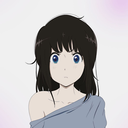

In [5]:
display(input)

epoch: 500; G_loss: 0.692250; D_loss: 1.387192


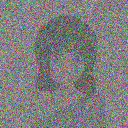

In [7]:
from IPython.display import clear_output

epochs = 500

for epoch in range(epochs):
    generator_random = tf.random.normal(shape=(1, 50))
    x_real = image_with_batch
    
    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
        x_fake = generator(generator_random, training=True)
        G_loss_curr = G_loss(discriminator, x_fake)
        D_loss_curr = D_loss(discriminator, x_real, x_fake)
    
    G_grad = G_tape.gradient(G_loss_curr, generator.trainable_variables)
    D_grad = D_tape.gradient(D_loss_curr, discriminator.trainable_variables)

    G_opt.apply_gradients(zip(G_grad, generator.trainable_variables))
    D_opt.apply_gradients(zip(D_grad, discriminator.trainable_variables))

    generated_image = generator(generator_random)
    tf.keras.preprocessing.image.save_img(f"output/epoch_{epoch}.png", generated_image[0,:,:])

    clear_output(wait=True)
    print('epoch: {}; G_loss: {:.6f}; D_loss: {:.6f}'.format(epoch+1, G_loss_curr, D_loss_curr))
    display(tf.keras.preprocessing.image.array_to_img(generated_image[0]))
    
    